# Exploratory Notebook 

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

## Set up

In [18]:
import os
import tqdm
from collections import defaultdict
from utils import load_config

import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio as rio
import xarray
from rioxarray.exceptions import NoDataInBounds 

from src.helpers.data_loader import (
    load_hydro_data, 
    load_station_info,
    load_meteo_data,
    load_water_flows,
    read_soil_data,
    read_altitude_data
)

from src.utils.plots import plot_hydrographic_maps
from src.preprocessing import (
    get_hydro_data,
    get_water_flow_data,
    aggregate_soil_data,
    load_and_aggregate_meteo_data,   
)

import matplotlib.pyplot as plt

### Constants

In [5]:
config = load_config()

In [6]:
RAW_DATA = config['raw_data']
PROCESSED_DATA = config['processed_data']
AREAS = config['areas']
TYPES = config['types']
BBOX = config['bbox']
CRS = config['crs']

### Preprocess hydrological zone data. 
- Understanding the spatial distribution of stations
- Decide aggregation scales for other variables

- [x] load regions
- [ ] spatial join with stations info (inner_join only)
- [ ]  rename to consolidate column names
- [ ]  add function to utils

In [69]:
%%time
brazil_hydro = load_hydro_data('brazil', RAW_DATA)
france_hydro = load_hydro_data('france', RAW_DATA)

CPU times: user 31.1 s, sys: 628 ms, total: 31.8 s
Wall time: 50.2 s


In [70]:
brazil_stations_train = load_station_info('brazil', 'train', RAW_DATA)
brazil_stations_eval = load_station_info('brazil', 'eval', RAW_DATA)
france_stations_train = load_station_info('france', 'train', RAW_DATA)
france_stations_eval = load_station_info('france', 'eval', RAW_DATA)

Text(0.5, 1.0, 'France Zones and Stations')

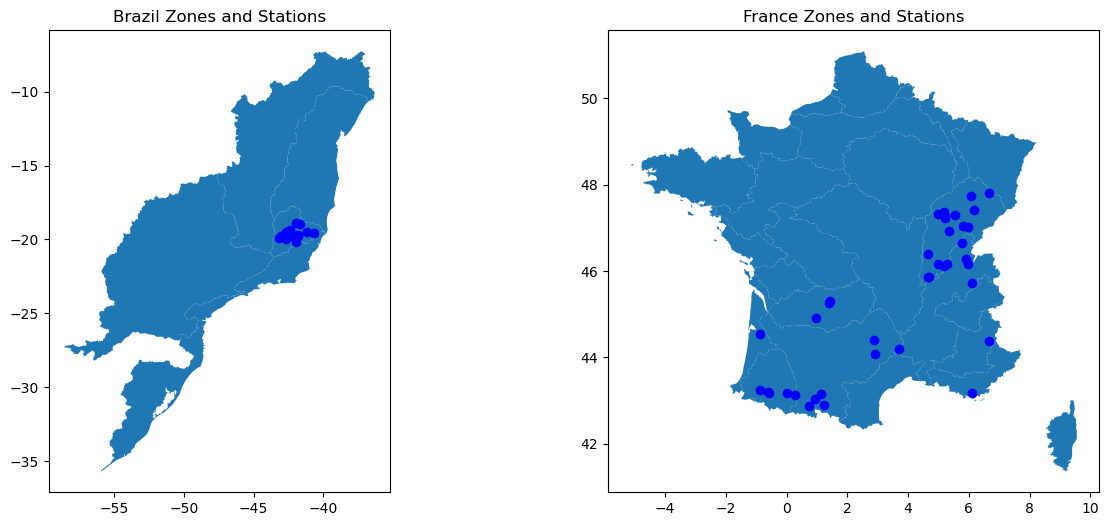

In [71]:
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
brazil_hydro['region'].plot(ax = ax[0])
france_hydro['region'].plot(ax = ax[1])
ax[0].set_title('Brazil Zones and Stations')

brazil_stations_eval.plot(ax = ax[0], color = 'blue')
france_stations_eval.plot(ax = ax[1], color = 'blue')
ax[1].set_title('France Zones and Stations')

In [72]:
brazil_stations_eval

,station_code,station_name,river,latitude,longitude,altitude,catchment,geometry
0,56960005,FAZENDA VARGEM ALEGRE,RIO MANHUAÇU,-20.1706,-41.9611,NaN,1070,POINT (-41.96110 -20.17060)
1,56850000,GOVERNADOR VALADARES,RIO DOCE,-18.8831,-41.9508,150.0,40500,POINT (-41.95080 -18.88310)
2,56990000,SÃO SEBASTIÃO DA ENCRUZILHADA,RIO MANHUAÇU,-19.4925,-41.1617,NaN,8720,POINT (-41.16170 -19.49250)
3,56610000,RIO PIRACICABA,RIO PIRACICABA,-19.9317,-43.1731,0.0,1163,POINT (-43.17310 -19.93170)
4,56425000,FAZENDA CACHOEIRA D'ANTAS,RIO DOCE,-19.9944,-42.6744,NaN,10100,POINT (-42.67440 -19.99440)
5,56920000,TUMIRITINGA,RIO DOCE,-18.9711,-41.6417,135.0,55100,POINT (-41.64170 -18.97110)
6,56719998,BELO ORIENTE,RIO DOCE,-19.3297,-42.3761,211.0,24200,POINT (-42.37610 -19.32970)
7,56539000,CACHOEIRA DOS ÓCULOS - MONTANTE,RIO DOCE,-19.7769,-42.4764,210.0,15900,POINT (-42.47640 -19.77690)
8,56659998,NOVA ERA IV,RIO PIRACICABA,-19.7656,-43.0328,552.0,3060,POINT (-43.03280 -19.76560)
9,56978000,SANTO ANTÔNIO DO MANHUAÇU,RIO MANHUAÇU,-19.6786,-41.8358,290.0,2350,POINT (-41.83580 -19.67860)


In [81]:
brazil_hydro_region = brazil_hydro['region'].to_crs(CRS).sjoin(brazil_stations_eval, predicate = 'within', how = 'left')

### Station relationship

In [97]:
# %%time
# brazil_watercourse = gpd.read_file(os.path.join(RAW_DATA, 'brazil', 'static_data', 'watercourse', 'geoft_bho_2017_curso_dagua.gpkg'))

spatial join watercourse takes too long. See alternative method. use altitude and river name to determine upstream downstream relationships between stations

In [105]:
brazil_stations_eval.river.value_counts()

river
RIO DOCE          6
RIO MANHUAÇU      4
RIO PIRACICABA    3
Name: count, dtype: int64

In [102]:
france_stations_eval.river.value_counts()

river
OGNON                     3
AZERGUES                  2
TILLE                     2
ARAC                      1
ARBAS                     1
OUCHE                     1
REAL MARTIN               1
HERISSON                  1
VEZERE                    1
LEYRE                     1
RENON                     1
MAUDAN                    1
CHERAN                    1
VALSERINE                 1
GARDON DE SAINTE-CROIX    1
SERRE                     1
VEYLE                     1
ROSEIX                    1
MUZE                      1
REYSSOUZE                 1
ARROS                     1
NORGES                    1
GAVE D'OSSAU              1
DOUBS                     1
RHONE                     1
GROSNE                    1
SAISON                    1
ECHEZ                     1
VOLP                      1
LOYRE                     1
GAVE D'OLORON             1
LANTERNE                  1
UBAYE                     1
LOUE                      1
LISON                     1
Name: count, d

- river relationship is not useful for france as most of the rivers have only one station making it difficult to establish upstream downstream relationships.
- This could be useful for the brazil stations as spatio temporal relationships can explored judiciously

### Water flow

In [11]:
brazil_water_flow_train = load_water_flows('brazil', 'train', RAW_DATA)
brazil_water_flow_eval = load_water_flows('brazil', 'eval', RAW_DATA)

In [12]:
brazil_water_flow_train.shape, brazil_water_flow_eval.shape

((6579, 3), (1352, 3))

In [13]:
brazil_water_flow_eval.head()

,station_code,ObsDate,discharge
0,56425000,2004-01-04,251.959325
1,56425000,2004-01-11,348.068529
2,56425000,2004-01-18,566.969486
3,56425000,2004-01-25,431.364643
4,56425000,2004-03-28,267.894943


### Soil Data

In [14]:
brazil_soil_data = read_soil_data('brazil', RAW_DATA)
france_soil_data = read_soil_data('france', RAW_DATA)

In [15]:
n = 6
u = list(brazil_soil_data.data_vars)[n]
v = list(france_soil_data.data_vars)[n]

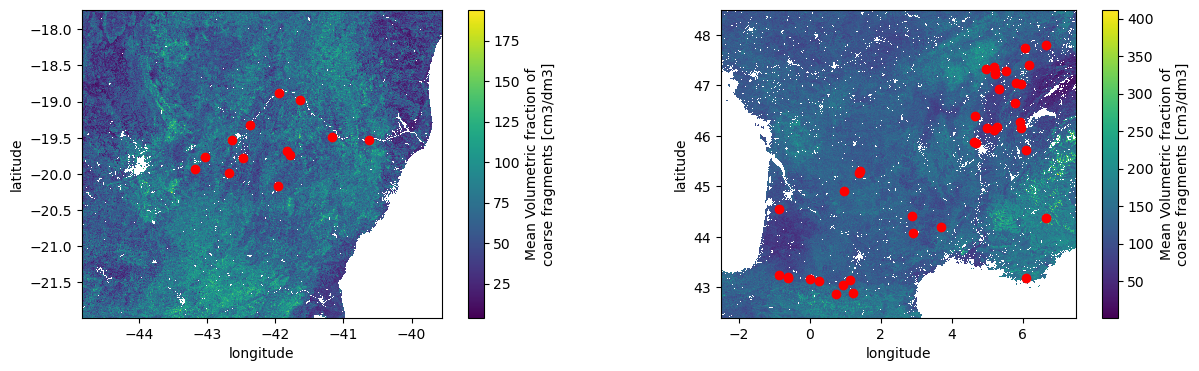

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
brazil_soil_data[u].plot(ax = ax[0])
brazil_stations_eval.plot(ax = ax[0], color = 'r')

france_soil_data[v].plot(ax = ax[1])
france_stations_eval.plot(ax = ax[1], color = 'r');

### Weather Data

- temperature
- precipitation
- soil moisture
- evaporation

Weather data has two more dates than the water flows dataset and needs to be address so aggregation is seamless for the train and eval sets.

In [21]:
brazil_meteo_train = load_meteo_data('brazil', 'train', RAW_DATA)
brazil_meteo_eval = load_meteo_data('brazil', 'eval', RAW_DATA)

In [22]:
brazil_meteo_eval.keys()

dict_keys(['precipitations', 'temperatures', 'soil_moisture', 'evaporation'])

In [23]:
brazil_meteo_eval['temperatures']

<xarray.Dataset> Size: 210kB
Dimensions:     (valid_time: 132, latitude: 18, longitude: 22)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 1kB 2004-01-04 ... 2010-01-03
  * longitude   (longitude) float64 176B -44.84 -44.59 -44.34 ... -39.84 -39.59
  * latitude    (latitude) float64 144B -17.74 -17.99 -18.24 ... -21.74 -21.99
    number      int32 4B ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 209kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-15T21:45 GRIB to CDM+CF via cfgrib-0.9.1...

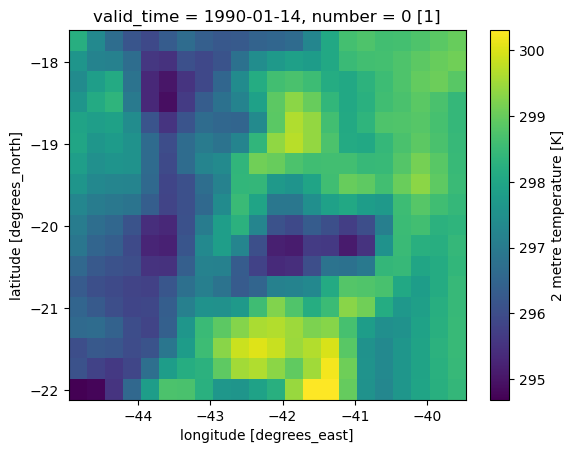

In [24]:
brazil_meteo_train['temperatures']['t2m'][1, :, :].plot()

In [25]:
max_date = brazil_water_flow_eval.ObsDate.max() + pd.Timedelta(7, unit = 'days')
max_date

Timestamp('2009-11-01 00:00:00')

In [26]:
buffer_scales = [50, 100]

weather_df = None

key_vars = {
    'precipitations' : 'tp', 
    'temperatures' : 't2m',
    'soil_moisture' : 'swvl1',
    'evaporation' : 'e'
}
    
for key, var in key_vars.items():
    keys_list = []
    data_var = brazil_meteo_eval[key][var]  # Extract variable
    data_var = data_var.rio.write_crs(CRS)
    for idx, row in brazil_stations_eval.iterrows():
        lat, lon = row.geometry.y, row.geometry.x

        # === 1. Point Sampling ===
        sampled_values = data_var.sel(latitude=lat, longitude=lon, method="nearest").to_dataframe().reset_index()
        # Filter by date range
        sampled_values = sampled_values[sampled_values.valid_time <= max_date]
        sampled_values["station_code"] = row.station_code
        sampled_values = sampled_values[['station_code', 'valid_time', var]]
    
        # === 2. Buffer-based Aggregation ===
        for buffer_size in buffer_scales:
            # Select data within buffer
            geom = row.geometry.buffer(buffer_size / 111 )
            clipped_data = data_var.rio.clip([geom])
            buffer_values = clipped_data.mean(dim = ['latitude', 'longitude'])
            buffer_values = buffer_values.to_dataframe().reset_index()
            buffer_values = buffer_values[buffer_values.valid_time <= max_date]
            buffer_values['station_code'] = buffer_values["station_code"] = row.station_code
            buffer_values = buffer_values.rename(columns={var: f'{var}_{buffer_size}km'})

            # Merge with point values using date
            sampled_values = sampled_values.merge(
                buffer_values[["valid_time", 'station_code', f'{var}_{buffer_size}km']],
                on=['station_code', "valid_time"],
                how="left"
            )
    
        keys_list.append(sampled_values)

    # Combine all DataFrames
    df_keys = pd.concat(keys_list, ignore_index=True)
    if not isinstance(weather_df, pd.DataFrame):
        weather_df = df_keys
    else:
        weather_df = weather_df.merge(
            df_keys,
            on = ['station_code', "valid_time"],
            how = 'left'
        )
weather_df

,station_code,valid_time,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,swvl1_100km,e,e_50km,e_100km
0,56960005,2004-01-04,0.000706,0.000763,0.000743,293.362488,294.220795,294.623474,0.496604,0.495490,0.490640,-0.000106,-0.000112,-0.000110
1,56960005,2004-01-11,0.000363,0.000414,0.000402,294.292694,295.052216,295.549072,0.492507,0.492499,0.488380,-0.000123,-0.000128,-0.000130
2,56960005,2004-01-18,0.000393,0.000477,0.000528,294.974518,295.840485,296.371918,0.494070,0.494040,0.490974,-0.000126,-0.000134,-0.000139
3,56960005,2004-01-25,0.000070,0.000071,0.000072,294.396210,295.333374,295.788513,0.441748,0.443167,0.440949,-0.000156,-0.000160,-0.000161
4,56960005,2004-02-01,0.000082,0.000087,0.000094,295.519623,296.248657,296.788574,0.413392,0.415214,0.410562,-0.000157,-0.000160,-0.000164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1685,56696000,2009-10-04,0.000103,0.000093,0.000080,297.116180,296.773010,296.259094,0.419924,0.402945,0.387387,-0.000113,-0.000105,-0.000106
1686,56696000,2009-10-11,0.000143,0.000145,0.000143,296.597626,296.243469,295.761017,0.425526,0.416924,0.403527,-0.000113,-0.000106,-0.000103
1687,56696000,2009-10-18,0.000055,0.000069,0.000088,298.149261,297.767029,297.230652,0.392450,0.392166,0.386992,-0.000130,-0.000127,-0.000129
1688,56696000,2009-10-25,0.000289,0.000288,0.000311,298.313385,297.914948,297.409088,0.447394,0.450820,0.447025,-0.000152,-0.000147,-0.000144


## Preprocess data

#### Get hydro stations
The get_hydro_data:
- Loads hydro data
- Loads stations data
- Filters hydro data to include only region, sector, sub_sector or zone the stations fall within
- Adds ids for region, sector, sub_sector and zone for each station to the stations_gdf
- returns the stations_gdf and hydro_gdf

In [221]:
hydro_data = {}
stations = {}
water_flows = {}
max_date = {}
meteo_data = {}

In [222]:
%%time
for area in AREAS:
    stations[area], hydro_data[area] = get_hydro_data(area, RAW_DATA, RAW_DATA)

CPU times: user 32.7 s, sys: 1.5 s, total: 34.2 s
Wall time: 52.5 s


In [224]:
stations['france']

,station_code,river,station_name,latitude,longitude,catchment,altitude,next_downstream_station,geometry,eval_only,id_region,CdRegionHydro_region,id_sector,CdSecteurHydro_sector,id_sub_sector,CdSousSecteurHydro_sub_sector,id_zone,CdZoneHydro_zone
0,6125320,MUZE,MONTJAUX (STAINT-HIPPOLYTE),44.080767,2.921202,112.0,335.0,6125360,POINT (2.92120 44.08077),False,11,O,69,O3,622,O34,6025,O345
1,6139640,REYSSOUZE,MONTAGNAT,46.170688,5.289284,84.4,242.0,6139390,POINT (5.28928 46.17069),False,21,U,10,U4,275,U40,1782,U400
2,6139790,LOUE,CHAMPAGNE-SUR-LOUE,47.042646,5.814381,1380.0,933.0,6139770,POINT (5.81438 47.04265),False,21,U,178,U2,233,U26,4911,U263
3,6139261,UBAYE,BARCELONNETTE (ABATTOIR),44.383261,6.651729,549.0,1135.0,6139260,POINT (6.65173 44.38326),False,6,X,179,X0,711,X04,744,X043
4,6139930,LANTERNE,FLEUREY-LES-FAVERNEY,47.747451,6.075586,1020.0,575.0,6139390,POINT (6.07559 47.74745),True,21,U,185,U0,787,U04,5588,U047
5,6119030,GAVE D'OLORON,OLORON-SAINTE-MARIE (OLORON-SNCF),43.197936,-0.608472,1085.0,222.0,-,POINT (-0.60847 43.19794),True,0,Q,127,Q7,324,Q70,5659,Q700
6,6124520,LOYRE,VOUTEZAC,45.305197,1.414628,103.0,152.0,6124500,POINT (1.41463 45.30520),True,14,P,181,P3,642,P32,2238,P323
7,6125440,VOLP,MONTBERAUD (STE-CROIX-VOLVESTRE),43.143790,1.141343,91.0,312.0,6125100,POINT (1.14134 43.14379),False,11,O,59,O0,134,O06,3877,O062
8,6119110,ECHEZ,LOUEY,43.174601,0.021673,89.6,342.0,-,POINT (0.02167 43.17460),False,0,Q,33,Q0,741,Q02,3638,Q021
9,6119040,SAISON,MAULEON-LICHARRE,43.245943,-0.874859,480.0,121.0,-,POINT (-0.87486 43.24594),False,0,Q,127,Q7,691,Q73,2878,Q732


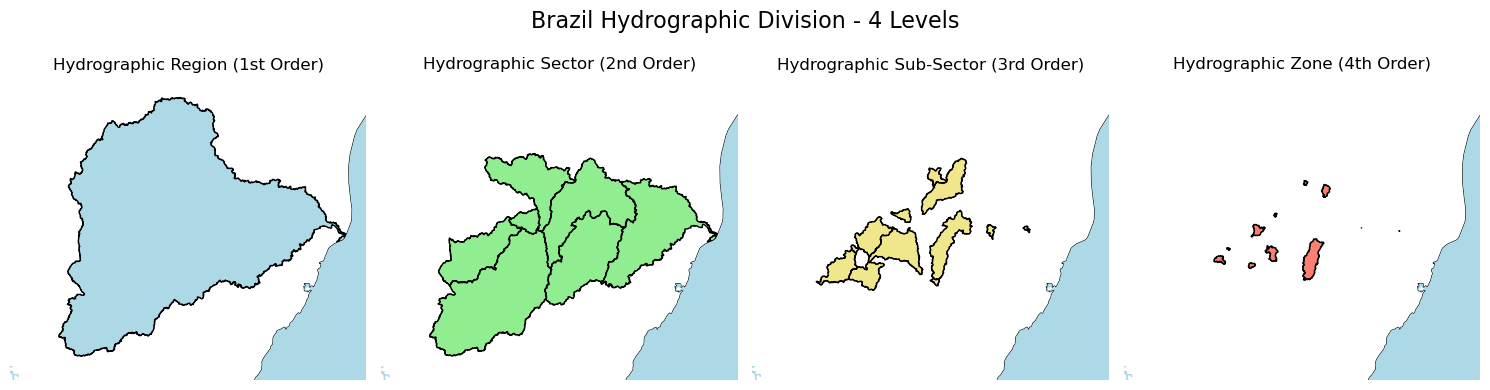

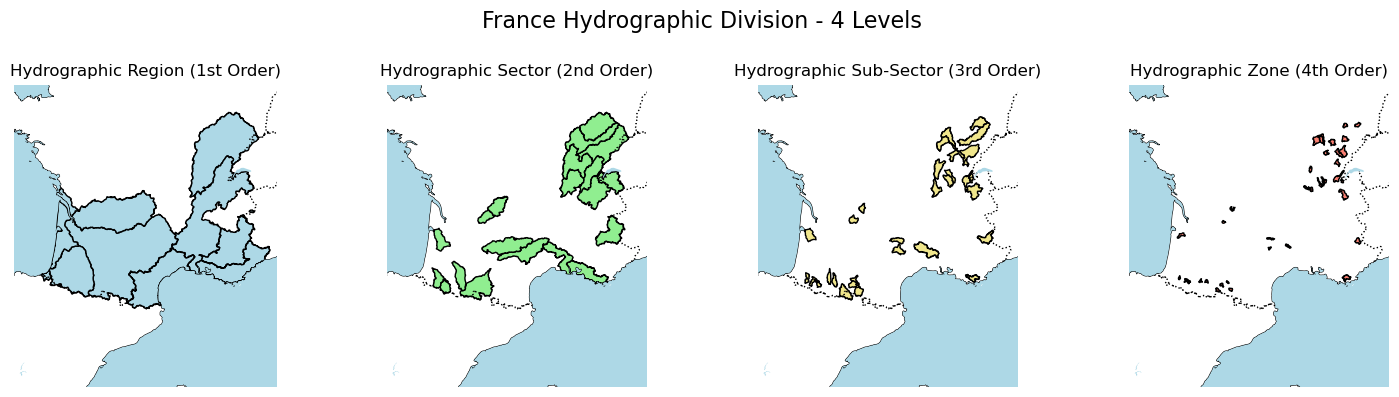

In [30]:
for area in AREAS:
    plot_hydrographic_maps(area, hydro_data, BBOX)

### Load soil data
Sample data at three different scales
- 1km (Local Scale) – Represents the immediate riverbank and riparian zone, capturing soil infiltration, erosion, and vegetation effects on discharge.

- 5km (Field Scale) – Covers the surrounding area that directly contributes surface runoff and subsurface flow, useful for analyzing land use impacts and hillslope hydrology.

- 25km Watershed Scale (Upstream Contributing Area) – The total upstream area draining to the station, ensuring all relevant hydrological influences are included.

In [229]:
%%time
for area in AREAS:
    stations[area] = aggregate_soil_data(area, RAW_DATA, stations[area], buffer_scales = None)

Processing soil data for brazil


  0%|                                                                                  | 0/13 [00:00<?, ?it/s]/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12

Processing soil data for france


  0%|                                                                                  | 0/39 [00:00<?, ?it/s]/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12/site-packages/geopandas/geodataframe.py:1543: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/dakinniyi/miniconda3/envs/zindi_geoai/lib/python3.12

CPU times: user 3min 38s, sys: 1min 16s, total: 4min 55s
Wall time: 7min 34s


### Load Meteorological data

In [230]:
for area in AREAS:
        water_flows[area] = get_water_flow_data(area, data_dir = RAW_DATA)
        max_date[area] = water_flows[area]['eval'].ObsDate.max() + pd.Timedelta(7, unit = 'days')

Loading water flow data for brazil
Loading water flow data for france


In [231]:
for area in AREAS:
        meteo_data[area] = load_and_aggregate_meteo_data(
            area = area, 
            data_dir = RAW_DATA, 
            stations_gdf = stations[area], 
            max_date = max_date[area], 
            buffer_scales = None, 
            crs = CRS
        )

In [232]:
meteo_data['france']['train'].shape

(21930, 14)

4

In [126]:
aa = water_flows['france']['train']

In [113]:
import seaborn as sns

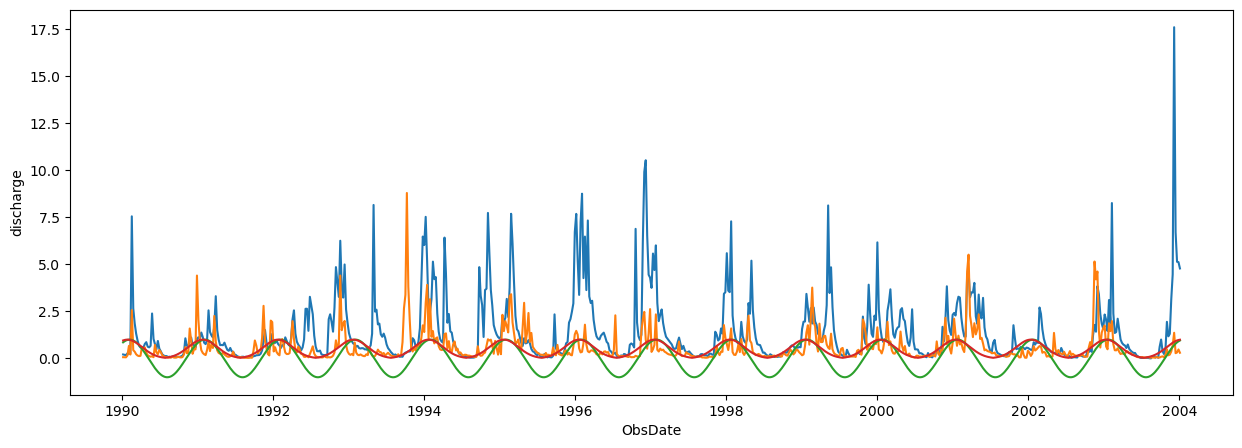

In [320]:
plt.figure(figsize = (15, 5))
sns.lineplot(aa[aa.station_code == 6125320], x = 'ObsDate', y = 'discharge')
# sns.lineplot(aa[aa.station_code == 56850000], x = 'ObsDate', y = 'discharge')
sns.lineplot(aa[aa.station_code == 6139640], x = 'ObsDate', y = 'discharge')
# sns.lineplot(aa[aa.station_code == 6139360], x = 'ObsDate', y = 'discharge')
# # plt.figure(figsize = (15, 5))
plt.plot(aa[aa.station_code == 6125320].ObsDate, np.cos(np.pi * ((2 / 52) ) * (np.arange(731) - 4.5)))
sigma = 10
plt.plot(aa[aa.station_code == 6125320].ObsDate, np.exp(-(((np.arange(731) + 23) % 52 - 52/2) ** 2) / (2 * sigma ** 2)))

### merge data

In [310]:
def merge_all_data(station, waterflow, meteo_data):
    station = station.copy()
    waterflow = waterflow.copy()
    meteo_data = meteo_data.copy()
    meteo_data = meteo_data.rename(columns = {'valid_time': 'ObsDate'})
    merged = meteo_data.merge(station, on = 'station_code', how = 'left')
    merged = merged.merge(waterflow, on = ['station_code', 'ObsDate'], how = 'left')
    return merged

In [312]:
merged = defaultdict(dict)
for area in AREAS:
    for key in ['train', 'eval']:
        station = stations[area]
        if key == 'train':
            station = station[~station.eval_only]
        merged[area][key] = merge_all_data(station, water_flows[area][key], meteo_data[area][key])

In [314]:
merged['france']['train']

,station_code,ObsDate,tp,tp_50km,tp_100km,t2m,t2m_50km,t2m_100km,swvl1,swvl1_50km,...,sand_100-200cm_mean_25km_std,sand_15-30cm_mean_25km_mean,sand_15-30cm_mean_25km_std,sand_30-60cm_mean_25km_mean,sand_30-60cm_mean_25km_std,sand_5-15cm_mean_25km_mean,sand_5-15cm_mean_25km_std,sand_60-100cm_mean_25km_mean,sand_60-100cm_mean_25km_std,discharge
0,6125320,1990-01-07,1.551424e-05,0.000020,0.000028,276.062927,276.063904,276.907867,0.447038,0.372005,...,46.448522,320.573308,56.092447,319.894636,51.718201,330.073874,63.203720,323.049756,51.652609,0.211429
1,6125320,1990-01-14,6.530966e-06,0.000008,0.000013,276.320190,276.307709,277.063690,0.450551,0.375596,...,46.448522,320.573308,56.092447,319.894636,51.718201,330.073874,63.203720,323.049756,51.652609,0.190286
2,6125320,1990-01-21,5.080587e-07,0.000002,0.000002,275.030426,275.281647,276.123169,0.436429,0.362603,...,46.448522,320.573308,56.092447,319.894636,51.718201,330.073874,63.203720,323.049756,51.652609,0.182429
3,6125320,1990-01-28,8.618265e-05,0.000122,0.000130,278.391632,278.152100,278.816101,0.452330,0.382994,...,46.448522,320.573308,56.092447,319.894636,51.718201,330.073874,63.203720,323.049756,51.652609,0.272429
4,6125320,1990-02-04,3.545483e-05,0.000054,0.000070,279.097168,278.964447,279.681915,0.467719,0.402156,...,46.448522,320.573308,56.092447,319.894636,51.718201,330.073874,63.203720,323.049756,51.652609,0.246000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21925,6139795,2003-12-07,1.788707e-05,0.000021,0.000041,278.382660,278.226929,278.129730,0.386718,0.390910,...,38.213038,202.481114,37.846477,215.041335,36.599517,184.092139,39.182882,220.766767,36.409038,4.374286
21926,6139795,2003-12-14,1.555908e-04,0.000136,0.000110,277.255554,276.994263,276.718658,0.379990,0.383507,...,38.213038,202.481114,37.846477,215.041335,36.599517,184.092139,39.182882,220.766767,36.409038,2.132857
21927,6139795,2003-12-21,2.325291e-04,0.000216,0.000189,275.852112,275.891418,276.190186,0.402066,0.400608,...,38.213038,202.481114,37.846477,215.041335,36.599517,184.092139,39.182882,220.766767,36.409038,7.171429
21928,6139795,2003-12-28,1.206086e-04,0.000106,0.000089,273.750183,273.699554,274.085999,0.394825,0.397471,...,38.213038,202.481114,37.846477,215.041335,36.599517,184.092139,39.182882,220.766767,36.409038,10.200000
